In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as m
%matplotlib inline
import astropy
from astropy.io import ascii
from astropy import units as u
import lightkurve as lk
from lightkurve import search_targetpixelfile as tpf

In [2]:
kep7 = tpf('Kepler-7', quarter = 3, cadence = 'long').download()

In [3]:
# kep7.plot(frame = 100, scale = 'log', show_colorbar = True);

In [4]:
lc_kep7 = kep7.to_lightcurve(aperture_mask = kep7.pipeline_mask)
# lc_kep7.plot();

In [5]:
flat_kep7, trend_kep7 = lc_kep7.flatten(window_length = 301, return_trend = True)
# ax_kep7 = lc_kep7.errorbar(label = 'Kepler-7')
# trend_kep7.plot(ax = ax_kep7, color = 'red', lw = 2, label = 'Trend');

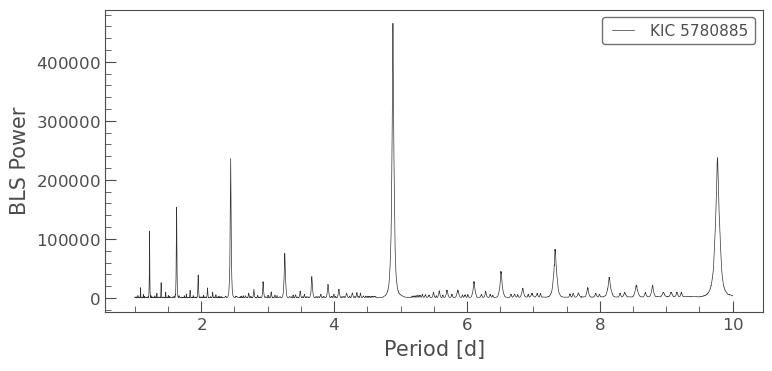

In [6]:
periodogram_kep7 = flat_kep7.to_periodogram(method = 'bls', period = np.arange(1,10,0.001))
periodogram_kep7.plot();

In [7]:
period_k7 = periodogram_kep7.period_at_max_power
duration_k7 = periodogram_kep7.duration_at_max_power
transit_k7 = periodogram_kep7.transit_time_at_max_power

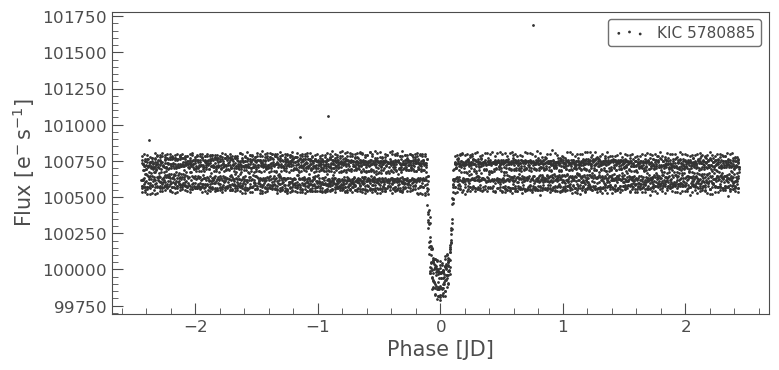

In [8]:
ax = lc_kep7.fold(period=period_k7, epoch_time=transit_k7).scatter()

##### Everything before this would not be used, it's just background information that students wouldn't necessarily need. 

# Investigating Kepler-7b

Kepler-7b is an exoplanet orbiting Kepler-7. The host star is 3090 light years away in the constellation Lyra. Kepler-7b was discovered by the transit method, and was one of the first objects identified in the Kepler mission. Kepler 7 is bigger and brighter than our sun, with a mass of 1.236 solar masses and a radius of 1.909 solar radii. Kepler 7 is a G0 star, with an equilibrium temperature of 6036 K.

In [9]:
rad_kep7 = 1.909 # solar radii
mass_kep7 = 1.236 # solar masses
temp_kep7 = 6036 # K

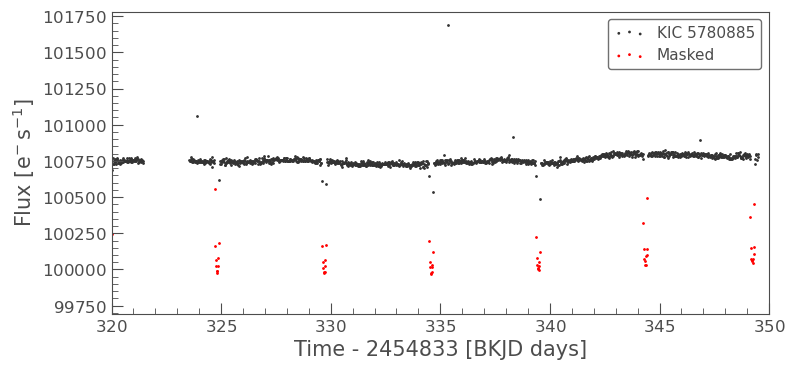

In [10]:
planet_mask = periodogram_kep7.get_transit_mask(period = period_k7, transit_time = transit_k7, duration = duration_k7)

masked_lc = lc_kep7[~planet_mask]
ax1 = masked_lc.scatter();
lc_kep7[planet_mask].scatter(ax = ax1, c = 'r', label = 'Masked');
ax1.set_xlim(320,350);

a) Given the above periodogram, estimate the period of the planet's orbit.

In [11]:
estimated_period = 4.9 # days

print(f'Estimated period for Kepler-7b: {estimated_period} days')
print(f'Best fit period for Kepler-7b: {period_k7:.3}')  # this isn't necessary to include, just a good check

Estimated period for Kepler-7b: 4.9 days
Best fit period for Kepler-7b: 4.88 d


b) Use Kepler's Third Law to determine the semi-major axis of the planet's orbit.

In [12]:
def kep_3_law(P, M_star):
    P = P / 365 # converting our estimated period from days into years
    a_3 = M_star * P**2 # calculating semi-major axis cubed
    a = np.cbrt(a_3)
    return a

In [13]:
sma_kep7 = kep_3_law(estimated_period, mass_kep7)

print(f"The semi-major axis of Kepler-7b is {sma_kep7:.3} AU")

The semi-major axis of Kepler-7b is 0.0606 AU


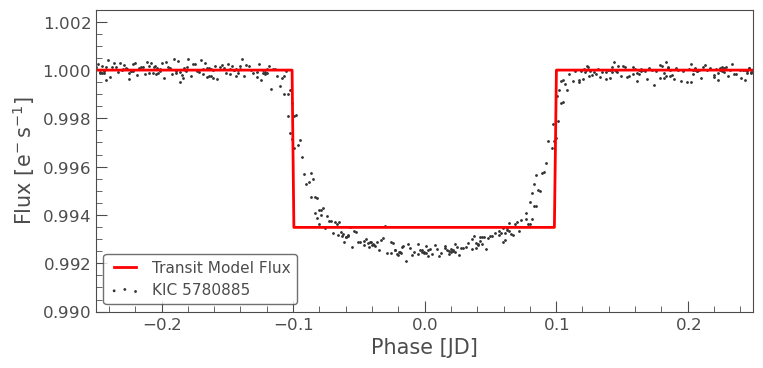

In [14]:
planet_model = periodogram_kep7.get_transit_model(period = period_k7, transit_time = transit_k7, duration = duration_k7)

ax2 = flat_kep7.fold(period_k7, transit_k7).scatter()
planet_model.fold(period_k7, transit_k7).plot(ax = ax2, c = 'r', lw = 2)
ax2.set_xlim(-0.25,0.25)
ax2.set_ylim(0.99,1.0025);

c) Based on the flux vs phase graph, estimate the change in flux for one transit.

In [15]:
estimated_flux = 0.008  # unitless

d) Use the depth found in c) and the radius of the star to determine the size of the planet.

In [16]:
# drop = r_planet^2 / R_Star^2

rad_k7b = np.sqrt((rad_kep7**2) * estimated_flux) # radius in solar radii
rad_kep7b = rad_k7b * 109.076 # radius in earth radii

print(f'The radius of Kepler-7b is: {rad_kep7b:.3} earth radii')

## Depending on how the flux is estimated, the radius will differ between 
## 16.1 (for a flux of 0.006, estimated from the transit model) and 
## 18.6 (for a flux of 0.008, edtimated from the very bottom of the data points)

The radius of Kepler-7b is: 18.6 earth radii


e) Find the equilibrium temperature of the planet. Assume a bond albedo of 0.3 (given by NEA).

In [17]:
# SMA and temp of star, size of the star gives equilibrium temp of planet
# T_eq = T_star*sqrt(R/2a)(1 - A_B)^(1/4) where A_B is bond albedo 
# The equilibrium temperature of the planet is independent of its size

bond_albedo = 0.3 # given by NEA, unitless

def temp(T_star, R_star, sma_planet):
    R_star = R_star * 0.00465047 # converting solar radii to AU
    x = np.sqrt(R_star / (2 * sma_planet))
    y = (1 - bond_albedo) ** (1/4)
    equil_temp = T_star * x * y
    return equil_temp
    
temp_kep7b = temp(temp_kep7, rad_kep7, sma_kep7)

print(f'The equilibrium temperature of the planet is {temp_kep7b:.6} K')

The equilibrium temperature of the planet is 1494.02 K


f) Using Figure 2 from Latham, et al 2010 (doi:10.1088/2041-8205/713/2/L140), estimate the radial velocity. Then use the period and semi-major axis to determine the orbital velocity of the planet. Finally, find the mass of the planet and report it in terms of Jupiter masses. (1047 M_Jupiter ~ 1 M_Sun)

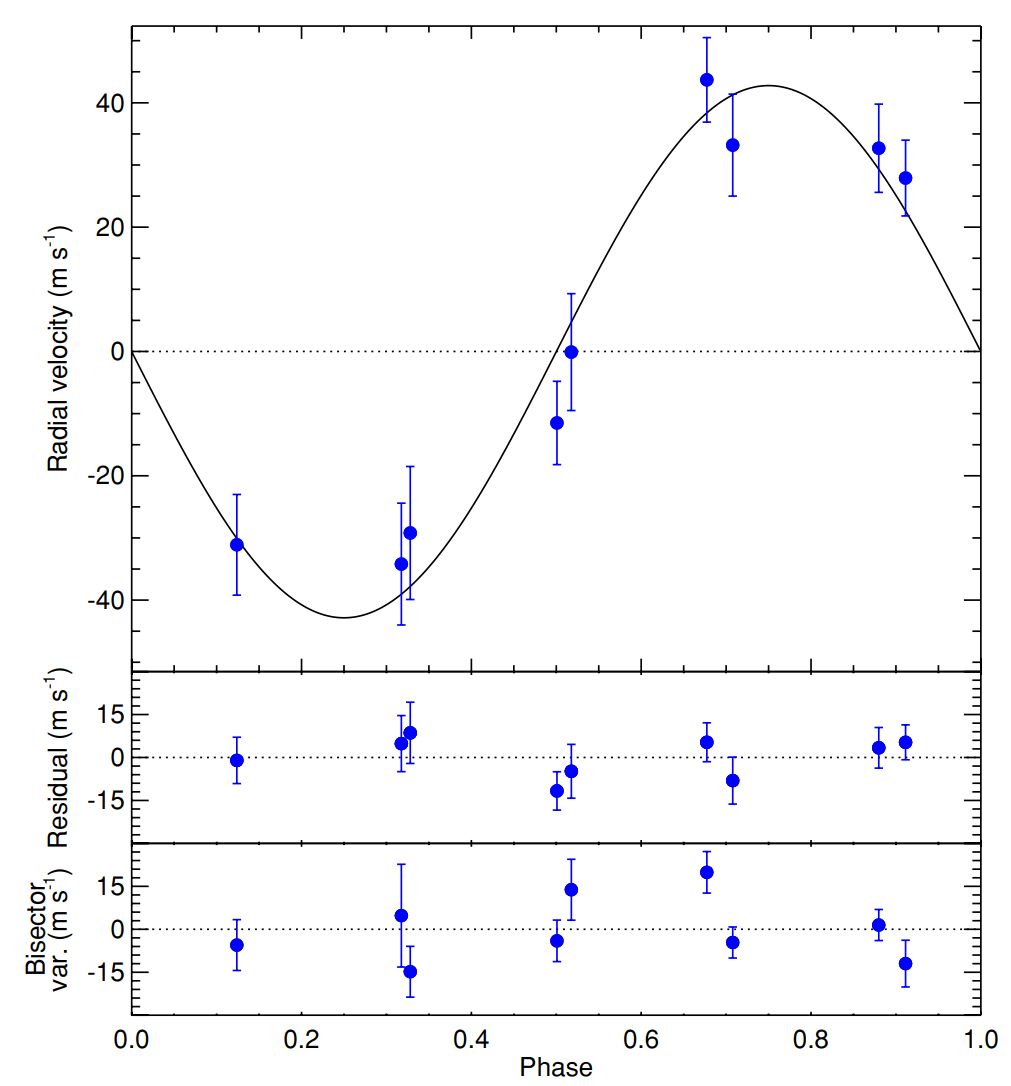

In [18]:
from IPython.display import Image
Image(filename='radial velocity kep7b.PNG', width=500)

In [19]:
radv_kep7b = 42.9 # radial velocity of the planet in m/s

In [20]:
# orbital velocity = 2 * pi * a / P
orb_v = 2 * np.pi * sma_kep7 / (estimated_period / 365) # AU/year

In [21]:
## combine Kepler's Third Law with conservation of momentum to determine the planetary mass
## M_p = a^3 / (P^2 * (1 + orbital_velocity / radial_velocity))

def mass(sma, period, rad_v, orb_v):
    rad_v = rad_v * 60 * 60 * 24 * 365 / 1.496e11 # converting m/s to AU/year
    period = period / 365 # converting days to years
    vels = orb_v / rad_v
    m_p = sma**3 / (period**2 * (1 + vels)) # calculating planetary mass
    m_p *= 1047 # converting from solar masses to jupiter masses
    return m_p

In [22]:
mass_kep7b = mass(sma_kep7, estimated_period, radv_kep7b, orb_v)

print(f'The mass of the planet is {mass_kep7b:.4} Jupiter masses')

The mass of the planet is 0.4124 Jupiter masses


#### Other potential questions:

g) Given the properties found above, talk about what this planet might be like. Would it be a pleasant place to live? What type of composition is it most likely to have? 

# Exoplanets and our Solar System

a) Read in data from the NASA Exoplanet Archive (NEA)

In [23]:
# this is a filtered dataset, containing only 
# necessary columns and confirmed KOIs
exo_data = ascii.read('exoplanet_data.csv')
exo_data.show_in_notebook()

# first we'll create a column for stellar radii in AU
exo_data['srad_au'] = exo_data['koi_srad'] * 0.00465047

# then we'll add a mask that cuts out all objects that will 
# end up having probabilities over 1 (because their semi-major 
# axes are less than the radius of the star)

good = exo_data['koi_sma'] >= exo_data['srad_au'] 

exo_data = exo_data[good]

b) Plot planetary radius vs orbital period for all confirmed Kepler Objects of Interest (KOIs). Overplot each of the Solar System planets as well.

<ipython-input-24-8d5b0050ecdb>:2: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(exo_data['koi_period']), np.log10(exo_data['koi_prad']), s = 1)


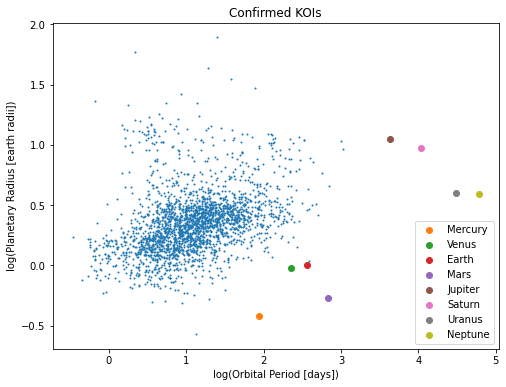

In [24]:
fig1,(ax1) = plt.subplots(1,1, figsize = (8,6))
ax1.scatter(np.log10(exo_data['koi_period']), np.log10(exo_data['koi_prad']), s = 1)
ax1.set_title('Confirmed KOIs')

for subpanel in [ax1]:
    subpanel.set_xlabel('log(Orbital Period [days])')
    subpanel.set_ylabel('log(Planetary Radius [earth radii])')

    subpanel.scatter(np.log10(87.97),np.log10(.383), label = 'Mercury')
    subpanel.scatter(np.log10(224.7),np.log10(.949), label = 'Venus')
    subpanel.scatter(np.log10(365.26),np.log10(1), label = 'Earth')
    subpanel.scatter(np.log10(687),np.log10(.532), label = 'Mars')
    subpanel.scatter(np.log10(4333),np.log10(11.21), label = 'Jupiter')
    subpanel.scatter(np.log10(10759),np.log10(9.45), label = 'Saturn')
    subpanel.scatter(np.log10(30687),np.log10(4.01), label = 'Uranus')
    subpanel.scatter(np.log10(60190),np.log10(3.88) , label = 'Neptune')
    subpanel.legend();
    

c) Talk about why we see so many more planets with larger radii and shorter periods than Earth's. Does this have to do with the actual abundance of earth-like exoplanets in the universe or is this due to other factors?

# The Abundance of Earths ("$\eta_{earth}$")

a) Eta-earth is fraction of earth-like planets orbiting sun-like (or, for our purposes, low mass) stars that we find in the universe. In order to determine this fraction, we first have to define what we mean by "earth-like" planets and low mass stars. Use basic properties of Earth and the Sun to determine "earth-like" and low mass criteria. Give sources for your criteria.

In [25]:
# defining low mass stars
# We'll take all stars in the temperature ranges of K, G, and F stars

kgf_stars = (exo_data['koi_steff'] >= 3500) & (exo_data['koi_steff'] <= 7400)

In [26]:
# For a planet to be earth-like, it needs to be rocky. In order to be rocky, 
# a planet has to be between 0.5 and 2.5 earth radii, so we'll make that our first "earth-like" cut

planet_rad = (exo_data['koi_prad'] >= 0.5) & (exo_data['koi_prad'] <= 2.5)

# Next, we should look at orbital period. We know that earth's orbital period is 365,
# so next we'll limit our earth-like criteria to planets with orbital periods between 1 and 400 days.

planet_period = (exo_data['koi_period'] >= 1) & (exo_data['koi_period'] <= 400)

# Equilibrium temperature is also important to look at. Earth's equilibrium temperature 
# lies at 255 K (about -1 degree F). We'll define our equilibrium temperature criteria as 200-300 K.

planet_teq = (exo_data['koi_teq'] >= 200) & (exo_data['koi_teq'] <= 300)


# Now we can combine all of these to make our final earth-like cuts.

earth_like = np.logical_and(planet_rad, planet_period)
earth_like = np.logical_and(earth_like, planet_teq)

b) Find the probability of detecting a planet around a star. Remember to keep track of units! (the unit conversion was done at the very beginning...)

In [27]:
# The probability of detecting an earth-like planet around a low mass star
# is given by stellar radius / semi-major axis
# Make sure to use stellar radius in AU, not in solar radii

vis_prob = exo_data['srad_au'] / exo_data['koi_sma']

c) Plot the probability of finding a planet around a star vs the period of the planet. Then plot the probability of finding an *earth-like* planet vs the period of the planet.

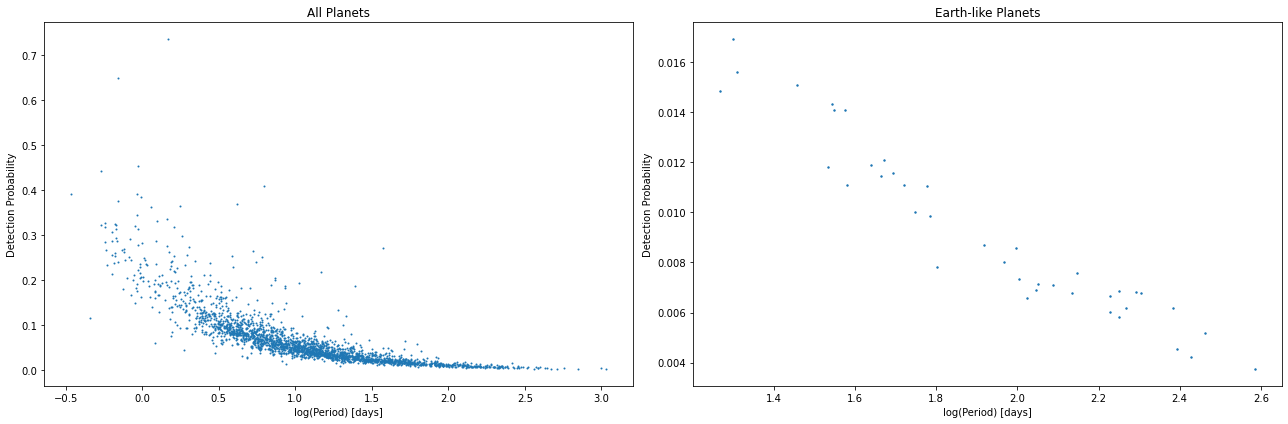

In [28]:
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize = (18, 6))
ax1.scatter(np.log10(exo_data['koi_period'])[good], vis_prob[good], s = 1)
ax1.set_title('All Planets')
ax2.scatter(np.log10(exo_data['koi_period'][earth_like]), vis_prob[earth_like], s = 2)
ax2.set_title('Earth-like Planets')

for subplot in [ax1, ax2]:
    subplot.set_xlabel('log(Period) [days]')
    subplot.set_ylabel('Detection Probability')
    
fig2.tight_layout()

d) Sum up the inverse probabilities of a planet being earth-like and divide by the number of low mass stars to get a value of $\eta_{earth}$. Talk about what this value physically means and relate it to our solar system. Is this a good average value based on what we see around us? 

In [29]:
kgf_stars = np.logical_and(kgf_stars, good)

earths = np.sum(1/vis_prob[earth_like])
suns = len(exo_data['kepid'][kgf_stars])
eta_earth = earths / suns
print(f'Eta Earth: {eta_earth:.2f}') 

Eta Earth: 2.14


## The Radius Valley

a) Using an appropriate range of radii, plot a histogram of planetary radii. Define `bins = np.logspace(0, np.log10(4), 30)` for the histogram bins, and make sure the x axis is in a log scale.

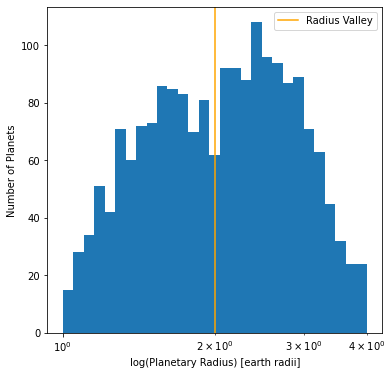

In [30]:
rads = (exo_data['koi_prad'] > 1) & (exo_data['koi_prad'] < 4)

bins = np.logspace(0,np.log10(4),30)
fig3, ax1 = plt.subplots(1,1, figsize = (6,6))
ax1.hist(exo_data['koi_prad'][rads], bins = bins)
ax1.semilogx()
ax1.axvline(2, color = 'orange', label = "Radius Valley")
ax1.set_xlabel('log(Planetary Radius) [earth radii]')
ax1.set_ylabel('Number of Planets')
ax1.legend();

b) Now, using a reasonable distinction for "high" and "low" orbital periods, plot the same histogram for each group. (Use similar bins as you did in part a). Also remember to include your radius cut when you make your high and low period cuts)

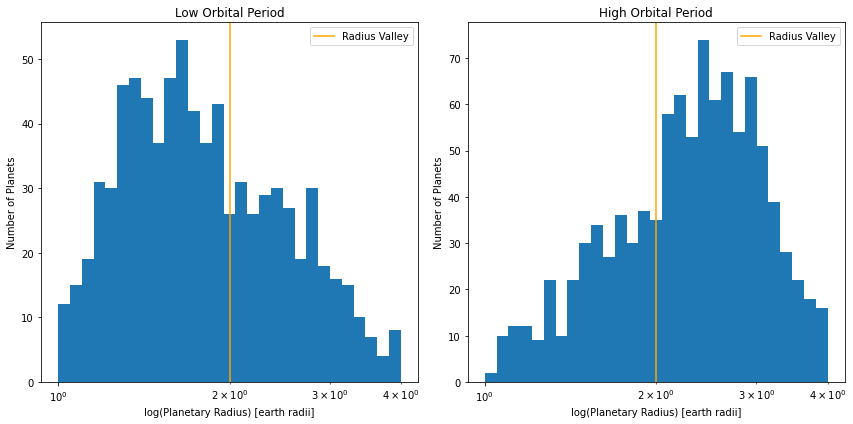

In [31]:
high = (exo_data['koi_period'] > 10) & (exo_data['koi_period'] < 100)
high = np.logical_and(rads, high)
low = (exo_data['koi_period'] > 1) & (exo_data['koi_period'] < 10)
low = np.logical_and(rads, low)

bins_high = np.logspace(0,np.log10(4),30)
bins_low = np.logspace(0,np.log10(4),30)

fig4, (ax1, ax2) = plt.subplots(1,2, figsize = (12,6))
ax1.hist(exo_data['koi_prad'][low], bins = bins_low)
ax1.axvline(2, color = 'orange', label = 'Radius Valley')
ax1.set_title('Low Orbital Period')

ax2.hist(exo_data['koi_prad'][high], bins = bins_high)
ax2.axvline(2, color = 'orange', label = 'Radius Valley')
ax2.set_title('High Orbital Period')

for subpanel in [ax1, ax2]:
    subpanel.semilogx()
    subpanel.set_xlabel('log(Planetary Radius) [earth radii]')
    subpanel.set_ylabel('Number of Planets')
    subpanel.legend()
    
fig4.tight_layout()

c) Does the difference in high and low period distributions make sense? Why or why not?